<a href="https://colab.research.google.com/github/LM1997610/NN/blob/main/NNDS_2023_Final_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks for Data Science Applications
## End-of-term homework: Advanced transfer learning

**Name**: *Luca Mazzucco*

**Matricola**: *1997610*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 12th** session, you should upload it by **January 9th, 23:59 Rome time**.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Instructions

1. The homework is divided into two exercises. The first one (**10 points**) is mandatory for everyone. The second one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

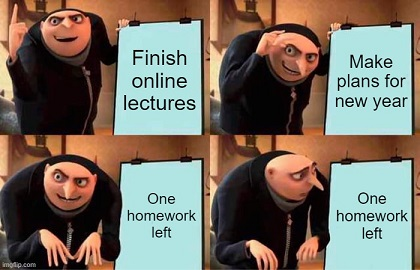

## Warmup: Data loading

**For this part, select an interesting dataset.**

*   This is similar to [Exercise 1 from the mid-term homework](https://colab.research.google.com/drive/1oDbshJeY62Id1O5pbsCrNFX9PdSY1ITP?usp=sharing), which you can check for completeness.
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

✍ **DESCRIPTION OF THE CODE**

*Provide a SHORT description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

In [10]:
! pip -q install  datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.5 MB/s eta 0:00:00


In [11]:
import warnings
from datasets import load_dataset
import matplotlib.pyplot as plt

In [12]:
# TODO: Insert all code here

dataset_name = "ccdv/patent-classification"

with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  data = load_dataset(dataset_name, split=['train[:20%]', 'validation[:20%]', 'test[:20%]'])

data

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

[Dataset({
     features: ['text', 'label'],
     num_rows: 5000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1000
 })]

In [13]:
train_data = data[0].to_tf_dataset()
val_data = data[1].to_tf_dataset()
test_data = data[2].to_tf_dataset()

In [14]:
train_data

<_PrefetchDataset element_spec={'text': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [15]:
def preprocess(el):
  # Transform the dataset into an (x,y) format.
  return el['text'], el['label']

In [16]:
train_data_p = train_data.map(preprocess).shuffle(1000).batch(16)
val_data_p = val_data.map(preprocess).shuffle(1000).batch(16)

In [17]:
train_data_p

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Exercise 1: Advanced transfer learning (10 points)

For this exercise, you are asked to implement some form of "advanced" transfer learning method. These include, but are not limited to, the content of Lecture 10 in the course, e.g.:

1.   **Parameter-efficient fine-tuning** (PEFT) methods (LoRA, adapters, soft prompting, ...).
2.   **Task vectors** and arithmetic in the weight space.
3.   **Model merging** and model combination (e.g., relative representations).

The following are useful surveys and papers you can take inspiration from. If you are in doubt, ask me before starting.

1. [Scaling Down to Scale Up: A Guide to Parameter-Efficient Fine-Tuning](https://arxiv.org/abs/2303.15647) - A survey on PEFT models.
2. [Modular Deep Learning](https://arxiv.org/abs/2302.11529) - A tutorial on the emerging paradigm of modular deep learning, in which networks are composed of modular building blocks. This is connected to PEFT, see in particular Section 7.
3. Examples of model merging: [model ratatouille](https://arxiv.org/abs/2212.10445), [git re-basin](https://arxiv.org/abs/2209.04836), [Fisher averaging](https://arxiv.org/abs/2111.09832).
4. Examples of task arithmetic: [simple arithmetic](https://arxiv.org/abs/2212.04089), [tangent space](https://arxiv.org/abs/2305.12827).

For this exercise, you can either transfer from two models that you trained autonomously (e.g., train one model on another dataset, add an adapter, fine-tune on the dataset you selected before), or fine-tune directly from a pre-trained model found on the web. For finding pre-trained models, you can check [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), [TensorFlow model garden](https://www.tensorflow.org/guide/model_garden?hl=it), or the [Hugging Face Hub](https://huggingface.co/docs/hub/index).

> 🟥 Remember that the homework must be done fully in TensorFlow, with no external libraries (when in doubt, ask).

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

In [1]:
! pip -q install --upgrade keras-nlp
! pip -q install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.4 which is incompatible.


In [2]:
import math
import keras
import keras_nlp

print(keras.__version__)

3.0.4


In [3]:
model = keras_nlp.models.BertClassifier.from_preset("bert_base_en_uncased", num_classes=9)

100%|██████████| 510/510 [00:00<00:00, 1.27MB/s]
100%|██████████| 418M/418M [00:27<00:00, 15.9MB/s]
100%|██████████| 547/547 [00:00<00:00, 610kB/s]
100%|██████████| 226k/226k [00:00<00:00, 306kB/s]


In [4]:
model.summary()

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 768), (None,      │ 109,482,240 │ padding_mask[0][0],            │
│                               │ None, 768)]               │             │ segment_ids[0][0],             │
│                               │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dropout_12 (Dropout)          │ (None, 768)               │           0 │ bert_backbone[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 9)                 │       6,921 │ dropout_12[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 109,489,161 (417.67 MB)

 Trainable params: 109,489,161 (417.67 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
class LoraLayer(keras.layers.Layer):
    def __init__(self, original_layer, rank=8, alpha=16, trainable=False,**kwargs,):

        # We want to keep the name of this layer the same as the original dense layer.
        original_layer_config = original_layer.get_config()
        name = original_layer_config["name"]

        kwargs.pop("name", None)

        super().__init__(name=name, trainable=trainable, **kwargs)

        self.rank = rank
        self.alpha = alpha

        self._scale = alpha / rank

        self._num_heads = original_layer_config["output_shape"][-2]
        self._hidden_dim = self._num_heads * original_layer_config["output_shape"][-1]

        # Layers.

        # Original dense layer.
        self.original_layer = original_layer
        # No matter whether we are training the model or are in inference mode,
        # this layer should be frozen.
        self.original_layer.trainable = False

        # LoRA dense layers.
        self.A = keras.layers.Dense(units=rank,
                                    use_bias=False,
                                    # Note: the original paper mentions that normal distribution was
                                    # used for initialization. However, the official LoRA implementation
                                    # uses "Kaiming/He Initialization".
                                    kernel_initializer=keras.initializers.VarianceScaling( scale=math.sqrt(5), mode="fan_in", distribution="uniform"),
                                    trainable=trainable, name=f"lora_A")

        # B has the same `equation` and `output_shape` as the original layer.
        # `equation = abc,cde->abde`, where `a`: batch size, `b`: sequence
        # length, `c`: `hidden_dim`, `d`: `num_heads`,
        # `e`: `hidden_dim//num_heads`. The only difference is that in layer `B`,
        # `c` represents `rank`.
        self.B = keras.layers.EinsumDense(equation=original_layer_config["equation"],
                                          output_shape=original_layer_config["output_shape"],
                                          kernel_initializer="zeros",
                                          trainable=trainable,
                                          name=f"lora_B")

    def call(self, inputs):
        original_output = self.original_layer(inputs)
        if self.trainable:
            # If we are fine-tuning the model, we will add LoRA layers' output to the original layer's output.
            lora_output = self.B(self.A(inputs)) * self._scale
            return original_output + lora_output

        # If we are in inference mode, we "merge" the LoRA layers' weights into
        # the original layer's weights - more on this in the text generation section!

        return original_output

In [6]:
#freeze all layers in encoder:

for n, layer in enumerate(model.layers[3].layers):
  if layer.name[:18] == 'transformer_layer_':
    layer.trainable = False
    print(f'{layer.name} -> trainable: {layer.trainable}')

transformer_layer_0 -> trainable: False
transformer_layer_1 -> trainable: False
transformer_layer_2 -> trainable: False
transformer_layer_3 -> trainable: False
transformer_layer_4 -> trainable: False
transformer_layer_5 -> trainable: False
transformer_layer_6 -> trainable: False
transformer_layer_7 -> trainable: False
transformer_layer_8 -> trainable: False
transformer_layer_9 -> trainable: False
transformer_layer_10 -> trainable: False
transformer_layer_11 -> trainable: False


In [7]:
RANK = 4
ALPHA = 16.0

In [8]:
for layer_idx in range(model.backbone.num_layers):
  decoder_layer = model.backbone.get_layer(f"transformer_layer_{layer_idx}")
  self_attention_layer = decoder_layer._self_attention_layer
  self_attention_layer._tracker.locked = False

  #Change query dense layer
  self_attention_layer._query_dense = LoraLayer(self_attention_layer._query_dense, rank=RANK, alpha=ALPHA, trainable=True)
  self_attention_layer._query_dense.trinable=True

  # Change value dense layer.
  self_attention_layer._value_dense = LoraLayer(self_attention_layer._value_dense, rank=RANK, alpha=ALPHA, trainable=True)
  self_attention_layer._value_dense.trinable=True

In [9]:
model.summary()

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 768), (None,      │ 109,482,240 │ padding_mask[0][0],            │
│                               │ None, 768)]               │             │ segment_ids[0][0],             │
│                               │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dropout_12 (Dropout)          │ (None, 768)               │           0 │ bert_backbone[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 9)                 │       6,921 │ dropout_12[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 109,489,161 (417.67 MB)

 Trainable params: 24,434,697 (93.21 MB)

 Non-trainable params: 85,054,464 (324.46 MB)

## Training the model:

In [18]:
# TODO: Your code here.

optimizer = keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=0.01, epsilon=1e-6)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, weighted_metrics=["accuracy"])

In [ ]:
history = model.fit(train_data_p, validation_data=val_data_p, epochs=20, verbose=2)

Epoch 1/20
313/313 - 666s - 2s/step - accuracy: 0.4810 - loss: 1.4437 - val_accuracy: 0.5650 - val_loss: 1.2598
Epoch 2/20
313/313 - 437s - 1s/step - accuracy: 0.6844 - loss: 0.9558 - val_accuracy: 0.5860 - val_loss: 1.2305
Epoch 3/20
313/313 - 435s - 1s/step - accuracy: 0.7886 - loss: 0.6251 - val_accuracy: 0.5720 - val_loss: 1.3802
Epoch 4/20
313/313 - 469s - 1s/step - accuracy: 0.8932 - loss: 0.3351 - val_accuracy: 0.5600 - val_loss: 1.6321
Epoch 5/20
313/313 - 437s - 1s/step - accuracy: 0.9568 - loss: 0.1593 - val_accuracy: 0.5620 - val_loss: 1.8302
Epoch 6/20
313/313 - 434s - 1s/step - accuracy: 0.9790 - loss: 0.0768 - val_accuracy: 0.5610 - val_loss: 2.0990
Epoch 7/20
313/313 - 438s - 1s/step - accuracy: 0.9918 - loss: 0.0380 - val_accuracy: 0.5420 - val_loss: 2.3170
Epoch 8/20
313/313 - 434s - 1s/step - accuracy: 0.9960 - loss: 0.0184 - val_accuracy: 0.5770 - val_loss: 2.4357
Epoch 9/20
313/313 - 433s - 1s/step - accuracy: 0.9986 - loss: 0.0118 - val_accuracy: 0.5730 - val_loss:

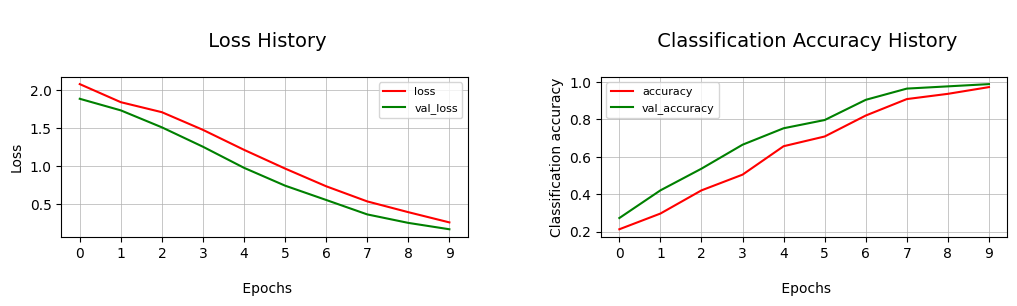

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(11, 3))
fig.tight_layout(pad=4, w_pad=6.5)

x = list(range(0, len(history.history["loss"])))

plot_info = [{'label_prefix': '', 'color': 'red'},
              {'label_prefix': 'val_', 'color': 'green'}]

for i, ax_index in enumerate([0, 1]):

    for info in plot_info:
        label = info['label_prefix'] + 'loss' if i == 0 else info['label_prefix'] + 'accuracy'
        value = history.history[label]
        ax[ax_index].plot(x, value, label=label, color=info['color'])

    ax[ax_index].set_title(f'\n {"Loss" if i == 0 else "Classification Accuracy"} History\n', fontsize=14)
    ax[ax_index].set_xlabel('\n Epochs')
    ax[ax_index].set_ylabel('Loss' if i == 0 else 'Classification accuracy')
    ax[ax_index].set_xticks(list(range(0, len(history.history["loss"]))))
    ax[ax_index].grid(linewidth=0.5)

    ax[ax_index].legend(loc="best", prop={'size': 8})

plt.show()

In [ ]:
#test_data = test_data.map(preprocess).shuffle(1000).batch(16)

In [31]:
test_loss, test_acc = model.evaluate(test_data, verbose=1)

print(f" >> test Loss: {round(test_loss, 4)}")
print(f" >> test Accuracy : {round(test_acc, 4)}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step - accuracy: 0.2905 - loss: 2.0217
 >> test Loss: 1.9738
 >> test Accuracy : 0.32


### Exercise 2: Interpreting the results (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 8/10). For a mark of 8/10 or higher, an additional point can also be recovered during the exam.**

> **To recap**: if you submitted the mid-term homework, implement only Exercise 1, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1 and 2 for a total of *15 points*.

[LIME](https://arxiv.org/abs/1602.04938) (**Local Interpretable Model-agnostic Explanations**) is a very common explainability method, which trains a small interpretable model (e.g., a linear model) around a prediction $f(x)$ to interpret the prediction. For this exercise:

1. Read carefully the original LIME paper.
2. Re-implement the LIME algorithm and test it on 1 or 2 predictions given by your neural network (from Exercise 1).
3. This must be done fully in TensorFlow (same as the previous exercise).
4. LIME requires to select how to represent the inputs (e.g., patches of the original image). Explain your choice below.
5. Analyze the results you obtain.

In [ ]:
# TODO: Implement and test LIME.

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

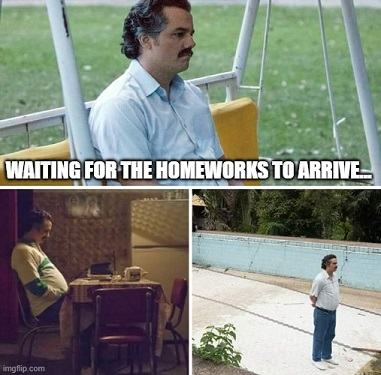